In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import metpy.calc as mpcalc
from metpy.calc import saturation_mixing_ratio
from metpy.units import units
from fig_params import fig_params
import pickle
import matplotlib as mpl

linewidth_default = 2.0
fig_text_default = 18.
fig_title_default = fig_text_default*1.5

plt.rc('lines', linewidth=linewidth_default)    
plt.rc('text', usetex=False)
plt.rc('font', size=fig_text_default, weight='normal',family='sans-serif')
plt.rc('axes',titlesize=fig_title_default,titleweight='bold')
mpl.rcParams['figure.dpi'] = 100

In [3]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()
def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print ("Toc: start time not set")
fig_params()

In [4]:
# constants
So = 1363
sigma = 5.67e-8
a = 0.3
Sw = So/4*(1-a)
g = 9.81
cp = 1004 #[J/kg/K]

gamma_crit = 6.5
# t = np.zeros(2*365*24);
cp = 1004 # J kg^-1 K^-1
L = 2.5 * 10**6 # J kg^-1

In [125]:
# initialize arrays
plev = np.arange(105000,0,-5000) # pressure array
m = 5000/g # mass = p/g

t = np.zeros(20*365*24);
T = np.zeros([np.size(plev),np.size(t)])
# T_strat = np.zeros([np.size(plev),np.size(t)])
epsilon = np.zeros(np.size(plev))
f_down = np.zeros([np.size(plev),np.size(t)])
f_up = np.zeros([np.size(plev),np.size(t)])
# flux arrays for dF
lw_up_top = np.zeros([np.size(plev),np.size(t)]) # upward LW 
lw_up_bot = np.zeros([np.size(plev),np.size(t)]) # ---
lw_down_top = np.zeros([np.size(plev),np.size(t)]) # downloward LW
lw_down_bot = np.zeros([np.size(plev),np.size(t)]) # ---

sw_down_top = np.zeros([np.size(plev),np.size(t)]) # downward SW top array
sw_down_bot = np.zeros([np.size(plev),np.size(t)]) # downward SW bot array 
dF = np.zeros([np.size(plev),np.size(t)]) # net radiative flux of layer

# initial conditions
T[:,0] = 50 # set all layers 50 Kelvin

# set piecewise epsilon array vals  
mask = plev>80000
epsilon[mask] = 0.3
mask = (plev<=80000) & (plev>40000)
epsilon[mask] = 0.2
mask = plev<=40000
epsilon[mask] = 0.1
epsilon[0] = 1 # surface epsilon 

# potential temperature
theta = np.zeros([np.size(plev),np.size(t)])

# calculate lapse rate
Rd = 287
g = 9.8
lapse_rate = np.zeros([np.size(plev)-1,np.size(t)])
dz = np.zeros([np.size(plev)-1,np.size(t)])

# Project 1
- ###  Radiative Equilibrium with only a troposphere (No ozone)
- Base model to build upon

In [ ]:
# len(t) = 100_000_000 seconds ~3.5 yrs

tic()
dt = 60*60 # every hour

# time loop
for i in np.arange(0,len(t)-1):

    
    
    # upward LW stream
    for j in np.arange(0,len(plev)):
        if j==0:
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
            emi_in = 0
            trans = 0
            absorption = 0
            lw_up_bot[j,i] = 0
            lw_up_top[j,i] = emi_out + trans
        else: # for 1,...,20
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
            emi_in = epsilon[j-1]*sigma*(T[j-1,i]**4)
            f_up[j,i] = emi_in + trans
            trans = (1-epsilon[j])*f_up[j,i]
            lw_up_bot[j,i] = f_up[j,i]

            lw_up_top[j,i] = emi_out + trans
    # downward LW stream
    for j in np.arange(len(plev)-1,-1,-1): # correct index for layer 20 is len(plev)-1
#         print(j)
        if j==20: # layer 20 (last atm layer)
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
            emi_in = 0
            trans = 0
            lw_down_bot[j,i] = emi_out + trans
            lw_down_top[j,i] = 0
        elif j==0:
            lw_down_top[j,i] = emi_out + trans
            lw_down_bot[j,i] = 0
        else: # 19,18,...,0
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
            emi_in = epsilon[j+1]*sigma*(T[j+1,i]**4)
            f_down[j,i] = emi_in + trans

            lw_down_top[j,i] = emi_in + trans
            trans = (1-epsilon[j])*f_down[j,i]
            lw_down_bot[j,i] = emi_out + trans

    # downward SW stream
    for j in np.arange(len(plev)-1,-1,-1):
        if j==0:
            sw_down_top[j,i] = (So/4)*(1-a)
            sw_down_bot[j,i] = 0 
        else:
            sw_down_top[j,i] = (So/4)*(1-a)
            sw_down_bot[j,i] = (So/4)*(1-a)
            
    # calculate (broadcast) net radiation in each layer for time step i
    dF[:,i] = lw_up_bot[:,i] - lw_up_top[:,i] + lw_down_top[:,i] \
    - lw_down_bot[:,i] + sw_down_top[:,i] - sw_down_bot[:,i]
    
    # calculate temperature array
    T[:,i+1] = T[:,i] + dF[:,i]/(m*cp)*dt

toc()

In [ ]:
# plotting
fig = plt.figure(figsize=(11,8),constrained_layout=True)
gs1 = gs.GridSpec(2,3,figure=fig)

ax1 = fig.add_subplot(gs1[0:,0:2])
plt.plot(T[:,-1],plev[:],label='T')
plt.plot(theta[:,-1],plev[:],label=r'$\theta$')
ax1.invert_yaxis(); plt.yscale('log')
plt.grid()
plt.yticks(plev[1::2], [str(int(val/100)) for val in plev[1::2]]);
plt.xlabel('Temperature [K]');
plt.ylabel('Pressure [hPa]');
plt.title('Radiative Equilibrium Temperature Profile without Ozone')
plt.legend();

ax2 = fig.add_subplot(gs1[0:,2:])
plt.title('Lapse Rate')
plt.plot(lapse_rate[:],plev[0:-1],label =r'$\Gamma = \frac{dT}{dz}*\nabla z$')
ax2.invert_yaxis(); plt.yscale('log')
plt.grid();
plt.legend();
plt.yticks(plev[1::2], [str(int(val/100)) for val in plev[1::2]]);
plt.xlabel(r'Lapse Rate [$K \; km^{-1}$]');
# plt.savefig('/Users/tyler/Desktop/SP22/ATS_606/figs/atmospheric_profile_no_ozone.png',dpi=300,bbox_inches='tight')

- ### Radiative Equilibrium with a stratosphere (with ozone)
- Base model simulates ozone through absorption of SW radiation by stratospheric layers

In [ ]:
# len(t) = 100_000_000 seconds ~3.5 yrs

tic()
dt = 60*60 # every hour

# time loop
for i in np.arange(0,len(t)-1):
# for i in np.arange(0,1000-1):

# upward LW stream
    for j in np.arange(0,len(plev)):
        if j==0:
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
#             print(emi_out)
            emi_in = 0
            trans = 0
            absorption = 0
            lw_up_bot[j,i] = 0
            lw_up_top[j,i] = emi_out + trans
#             print(f)
        else: # for 1,...,20
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
#             print(emi_out)
            emi_in = epsilon[j-1]*sigma*(T[j-1,i]**4)
            f_up[j,i] = emi_in + trans
            trans = (1-epsilon[j])*f_up[j,i]
#             lw_up_bot[j,i] = emi_in
            lw_up_bot[j,i] = f_up[j,i]

            lw_up_top[j,i] = emi_out + trans
#             print(f)
    # downward LW stream
    for j in np.arange(len(plev)-1,-1,-1): # correct index for layer 20 is len(plev)-1
#         print(j)
        if j==20: # layer 20 (last atm layer)
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
            emi_in = 0
            trans = 0
            lw_down_bot[j,i] = emi_out + trans
            lw_down_top[j,i] = 0
        elif j==0:
            lw_down_top[j,i] = emi_out + trans
            lw_down_bot[j,i] = 0
        else: # 19,18,...,0
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
            emi_in = epsilon[j+1]*sigma*(T[j+1,i]**4)
            f_down[j,i] = emi_in + trans

            lw_down_top[j,i] = emi_in + trans
            trans = (1-epsilon[j])*f_down[j,i]
            lw_down_bot[j,i] = emi_out + trans

    # downward SW stream
    for j in np.arange(len(plev)-1,-1,-1):
        if j==0:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_bot[j,i] = 0 

        elif j==20:
            sw_down_top[j,i] = (So/4)*(1-a)
            sw_down_abs = 0.05*((So/4)*(1-a))
            sw_down_bot[j,i] = 0.95*(So/4)*(1-a)
            
        elif j==19:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.025*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.025)*sw_down_top[j,i]
            
        elif j==18:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.0125*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.0125)*sw_down_top[j,i]
            
        elif j==17:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.00625*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.00625)*sw_down_top[j,i]
            
        elif j==16:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.003125*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.003125)*sw_down_top[j,i]
        else:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_bot[j,i] = sw_down_bot[j+1,i]          
            
    # calculate (broadcast) net radiation in each layer for time step i
    dF[:,i] = lw_up_bot[:,i] - lw_up_top[:,i] + lw_down_top[:,i] \
    - lw_down_bot[:,i] + sw_down_top[:,i] - sw_down_bot[:,i]
    
    # calculate temperature array
    T[:,i+1] = T[:,i] + dF[:,i]/(m*cp)*dt
    
    # calculate potential temperature 
    theta[:,i] = T[:,i]*((np.ones(21)*105000)/(plev[:]))**(0.286)


In [ ]:
# store variables [ozone, no convection]
# calculate potential temperature
theta = np.zeros([np.size(plev),np.size(t)])
for i in np.arange(0,len(t)):
    theta[:,i] = T[:,i]*((np.ones(21)*105000)/(plev[:]))**(0.286)

# calculate lapse rate
Rd = 287
g = 9.8
lapse_rate = np.zeros(20)
dz = np.zeros([np.size(plev),np.size(t)])
for i in np.arange(0,np.size(plev)-1):
    dz = ((Rd*T[i,-1])/g)*np.log(plev[i]/plev[i+1])
    lapse_rate[i] = (T[i+1,-1]-T[i,-1])/dz*1000


In [ ]:
# store variables for later use
T1 = T[:,-1]
theta1 = theta[:,-1]
lapse_rate1 = lapse_rate
with open('vars1.pkl','wb') as f:
    pickle.dump([T1,theta1,lapse_rate1],f)

# Project 2
- ### Simulate convection (convective adjustment)
- Simulate atmospheric stability through convective adjustment. This is done through taking sensible heat and moving it up layers until the atmopshere is statically stable.

In [ ]:
# len(t) = 100_000_000 seconds ~3.5 yrs

tic()
dt = 60*60 # every hour

# time loop
for i in np.arange(0,len(t)-1):
# for i in np.arange(0,1000-1):

# upward LW stream
    for j in np.arange(0,len(plev)):
        if j==0:
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
#             print(emi_out)
            emi_in = 0
            trans = 0
            absorption = 0
            lw_up_bot[j,i] = 0
            lw_up_top[j,i] = emi_out + trans
#             print(f)
        else: # for 1,...,20
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
#             print(emi_out)
            emi_in = epsilon[j-1]*sigma*(T[j-1,i]**4)
            f_up[j,i] = emi_in + trans
            trans = (1-epsilon[j])*f_up[j,i]
#             lw_up_bot[j,i] = emi_in
            lw_up_bot[j,i] = f_up[j,i]

            lw_up_top[j,i] = emi_out + trans
#             print(f)
    # downward LW stream
    for j in np.arange(len(plev)-1,-1,-1): # correct index for layer 20 is len(plev)-1
#         print(j)
        if j==20: # layer 20 (last atm layer)
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
            emi_in = 0
            trans = 0
            lw_down_bot[j,i] = emi_out + trans
            lw_down_top[j,i] = 0
        elif j==0:
            lw_down_top[j,i] = emi_out + trans
            lw_down_bot[j,i] = 0
        else: # 19,18,...,0
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
            emi_in = epsilon[j+1]*sigma*(T[j+1,i]**4)
            f_down[j,i] = emi_in + trans

            lw_down_top[j,i] = emi_in + trans
            trans = (1-epsilon[j])*f_down[j,i]
            lw_down_bot[j,i] = emi_out + trans

    # downward SW stream
    for j in np.arange(len(plev)-1,-1,-1):
        if j==0:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_bot[j,i] = 0 

        elif j==20:
            sw_down_top[j,i] = (So/4)*(1-a)
            sw_down_abs = 0.05*((So/4)*(1-a))
            sw_down_bot[j,i] = 0.95*(So/4)*(1-a)
            
        elif j==19:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.025*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.025)*sw_down_top[j,i]
            
        elif j==18:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.0125*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.0125)*sw_down_top[j,i]
            
        elif j==17:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.00625*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.00625)*sw_down_top[j,i]
            
        elif j==16:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.003125*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.003125)*sw_down_top[j,i]
        else:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_bot[j,i] = sw_down_bot[j+1,i]          
            
    # calculate (broadcast) net radiation in each layer for time step i
    dF[:,i] = lw_up_bot[:,i] - lw_up_top[:,i] + lw_down_top[:,i] \
    - lw_down_bot[:,i] + sw_down_top[:,i] - sw_down_bot[:,i]
    
    # calculate temperature array
    T[:,i+1] = T[:,i] + dF[:,i]/(m*cp)*dt
    
    # calculate potential temperature 
    theta[:,i] = T[:,i]*((np.ones(21)*105000)/(plev[:]))**(0.286)

# ######################################## CONVECTIVE ADJUSTMENT STEPS ########################################
#     test with:
#     gamma_crit = 6.5

    for j in np.arange(0,len(plev)-1): # one less layer, b/c layer pair
    
        if j in [0,1,2,3,4,5]:
            
            # if j=0,:5: do convective adjustment again
            # calc gamma env
            dz = (Rd*T[j,i+1]/g)*np.log((plev[j]-2500)/(plev[j+1]-2500))
            lapse_rate = -1*(T[j+1,i+1]-T[j,i+1])/dz*1000

            # calc dq/dT using metpy
            dq_star = (saturation_mixing_ratio( (plev[j+1]-2500)*units.Pa, (T[j+1,i+1])*units.K) - \
                       saturation_mixing_ratio( (plev[j]-2500)*units.Pa, (T[j,i+1])*units.K)).magnitude
            dT = T[j+1,i+1]-T[j,i+1]
            dqdT = dq_star/dT
            gamma_crit = 9.8/(1+(L*dqdT/cp))
        #         print('time:', i, 'plev:',plev[j],lapse_rate, gamma_crit)
        #         print('dqdt',dqdt)

            tolerance = 0.1
            while lapse_rate > gamma_crit+tolerance: #unstable atm
                # do convective adjustment
        #             T[j+1,i+1] = ((T[j,i+1] + T[j+1,i+1] - (gamma_crit/1000)*dz[j,i+1]))/2
        #             T[j,i+1] = T[j+1,i+1] + (gamma_crit/1000)*dz[j,i+1]
                T[j+1,i+1] = (T[j,i+1] + T[j+1,i+1] - (gamma_crit/1000)*dz)/2
                T[j,i+1] = T[j+1,i+1] + (gamma_crit/1000)*dz


                lapse_rate = -1*(T[j+1,i+1]-T[j,i+1])/dz*1000
        else: 
             
            # if j=0,:5: do convective adjustment again
            # calc gamma env
            dz = (Rd*T[j,i+1]/g)*np.log((plev[j]-2500)/(plev[j+1]-2500))
            lapse_rate = -1*(T[j+1,i+1]-T[j,i+1])/dz*1000

            # calc dq/dT using metpy
            dq_star = (saturation_mixing_ratio( (plev[j+1]-2500)*units.Pa, (T[j+1,i+1])*units.K) - \
                       saturation_mixing_ratio( (plev[j]-2500)*units.Pa, (T[j,i+1])*units.K)).magnitude
            dT = T[j+1,i+1]-T[j,i+1]
            dqdT = dq_star/dT
            gamma_crit = 9.8/(1+(L*dqdT/cp))
        #         print('time:', i, 'plev:',plev[j],lapse_rate, gamma_crit)
        #         print('dqdt',dqdt)

            tolerance = 0.1
            while lapse_rate > gamma_crit+tolerance: #unstable atm
                # do convective adjustment
        #             T[j+1,i+1] = ((T[j,i+1] + T[j+1,i+1] - (gamma_crit/1000)*dz[j,i+1]))/2
        #             T[j,i+1] = T[j+1,i+1] + (gamma_crit/1000)*dz[j,i+1]
                T[j+1,i+1] = (T[j,i+1] + T[j+1,i+1] - (gamma_crit/1000)*dz)/2
                T[j,i+1] = T[j+1,i+1] + (gamma_crit/1000)*dz


                lapse_rate = -1*(T[j+1,i+1]-T[j,i+1])/dz*1000
toc()

In [ ]:
##### recalculate variables after convective adjustment
# recalculate lapse rate
dz_array = np.zeros(20)
lapse_rate = np.zeros(20)
for j in np.arange(0,len(plev)-1):
    dz_array[j] = ((Rd*T[j,-1]/g)*np.log((plev[j]-2500)/(plev[j+1]-2500)))
    lapse_rate[j] = -1*(T[j+1,-1]-T[j,-1])/dz_array[j]*1000
    
# recalculate theta with adjusted temperature (convection)
theta[:,-1] = T[:,-1]*((np.ones(21)*105000)/(plev[:]))**(0.286)


In [ ]:
# # store variables for later use
# T2 = T[:,-1]
# theta2 = theta
# lapse_rate2 = lapse_rate
# with open('vars2.pkl','wb') as f:
#     pickle.dump([T2,theta2,lapse_rate2],f)

In [46]:
# load in vars for plot comparison
with open('vars1.pkl','rb') as f:
    T1,theta1,lapse_rate1 = pickle.load(f)
with open('vars2.pkl','rb') as f:
    T2,theta2,lapse_rate2 = pickle.load(f)

In [ ]:
fig = plt.figure(figsize=(15,10))
gs1 = gs.GridSpec(2,3,figure=fig)

ax1 = fig.add_subplot(gs1[0:,0:2])
plt.plot(T1[:],plev,linestyle='dashdot',label='T w/o convection')
plt.plot(theta1[:],plev,linestyle='dashdot',label=r'$\theta$ w/o convection')
plt.plot(T2[:],plev,alpha=0.7,label='T w/ convection ')
plt.plot(theta2[:,-1],plev,alpha=0.7,label=r'$\theta$ w/ convection')
plt.grid();
plt.yscale('log');
plt.ylim( (pow(10,4),pow(10,5)) )
plt.yticks(plev[:], [str(int(val/100)) for val in plev[:]]);
ax1.invert_yaxis(); # have this at end, plt.plot changes the axis back
plt.legend(loc='lower right',prop={'size':15})
plt.xlabel('Temperature [K]')
plt.ylabel('Pressure [hPa]')
#########
ax2 = fig.add_subplot(gs1[0:,2:])
plt.plot(lapse_rate2,plev[0:-1]-2500,label='Convection')
plt.plot(lapse_rate1*-1,plev[0:-1]-2500,label='No convection')
plt.plot(np.ones(20)*9.8,plev[0:-1]-2500,linestyle='dashdot',label=r'$\Gamma_d$ = -9.8 $K\;km^{-1}$')
plt.plot(np.ones(20)*6.5,plev[0:-1]-2500,linestyle='dashdot',label=r'$\Gamma_s$ = -6.5 $K\;km^{-1}$')
plt.grid();
plt.yscale('log');
plt.ylim( (pow(10,4),pow(10,5)) )
plt.yticks(plev[:], [str(int(val/100)) for val in plev[:]]);
plt.xlabel('Lapse Rate [K km-1]')
ax2.invert_yaxis(); # have this at end, plt.plot changes the axis back
plt.legend(prop={'size':10},ncol=2);
# plt.savefig('/Users/tyler/Desktop/SP22/ATS_606/figs/Project2_plot.png',dpi=500,bbox_inches='tight')

# Part 3: Adding a Slab Ocean Model

In [75]:
# height of slab ocean
h = 5
# density of ocean water
rho = 1.25 # kg/m3
# specific heat
cp = 1004 # J/kg/K
cw = 4218
rhow = 1000
Ce = 8e-3
V = 10 # m/s $what is that again
SH = np.zeros(len(t))


In [76]:
# question a) test ocean slab model 
# works if ocean slab model at 5m depth == previous model 

# set piecewise epsilon array vals  
mask = plev>80000
epsilon[mask] = 0.3
mask = (plev<=80000) & (plev>40000)
epsilon[mask] = 0.2
mask = plev<=40000
epsilon[mask] = 0.1
epsilon[0] = 1 # surface epsilon

SH = np.zeros(len(t))
T[:,0] = final_T_prof
h=5
tic()
dt = 60*60 # every hour

# time loop
for i in np.arange(0,len(t)-1):
# for i in np.arange(0,1000-1):

    # upward LW stream #index good
    for j in np.arange(0,len(plev)):
        if j==0:
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
            emi_in = 0 # no energy in from bottom layer
            trans = 0
            lw_up_bot[j,i] = 0
            lw_up_top[j,i] = emi_out + trans
#             print(f)
        else: # for 1,...,20
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
#             print(emi_out)
            emi_in = epsilon[j-1]*sigma*(T[j-1,i]**4)
            f_up[j,i] = emi_in + trans
            trans = (1-epsilon[j])*f_up[j,i]
#             lw_up_bot[j,i] = emi_in
            lw_up_bot[j,i] = f_up[j,i]

            lw_up_top[j,i] = emi_out + trans
#             print(f)
    # downward LW stream  
    for j in np.arange(len(plev)-1,-1,-1):  # outputs 20 to 0, end @ 0 bc +1, starts at 20 bc +1 
        # correct index for layer 20 is len(plev)-1
        if j==20: # layer 20 (last atm layer)
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
            emi_in = 0
            trans = 0
            lw_down_bot[j,i] = emi_out + trans
            lw_down_top[j,i] = 0
        elif j==0:
            lw_down_top[j,i] = emi_out + trans
            lw_down_bot[j,i] = 0
        else: # 19,18,...,1
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
            emi_in = epsilon[j+1]*sigma*(T[j+1,i]**4)
            f_down[j,i] = emi_in + trans

            lw_down_top[j,i] = emi_in + trans
            trans = (1-epsilon[j])*f_down[j,i]
            lw_down_bot[j,i] = emi_out + trans

    # downward SW stream
    for j in np.arange(len(plev)-1,-1,-1): # index good
        if j==0:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_bot[j,i] = 0 

        elif j==20:
            sw_down_top[j,i] = (So/4)*(1-a)
            sw_down_abs = 0.05*((So/4)*(1-a))
            sw_down_bot[j,i] = 0.95*(So/4)*(1-a)
            
        elif j==19:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.025*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.025)*sw_down_top[j,i]
            
        elif j==18:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.0125*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.0125)*sw_down_top[j,i]
            
        elif j==17:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.00625*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.00625)*sw_down_top[j,i]
            
        elif j==16:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.003125*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.003125)*sw_down_top[j,i]
        else:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_bot[j,i] = sw_down_bot[j+1,i]          
#   ################################ SENSIBLE HEAT ########################################
    # calculate (broadcast) net radiation in each layer for time step i
    dF[:,i] = lw_up_bot[:,i] - lw_up_top[:,i] + lw_down_top[:,i] \
    - lw_down_bot[:,i] + sw_down_top[:,i] - sw_down_bot[:,i]
    
    SH[i] = rho*cp*Ce*V*(T[0,i]-T[1,i])

    dF[0,i] = dF[0,i] - SH[i]
    dF[1,i] = dF[1,i] + SH[i]
    
    # calculate temperature array
    T[:,i+1] = T[:,i] + dF[:,i]/(m*cp)*dt
#     m_ocean = rhow*h
    T[0,i+1] = T[0,i] + dF[0,i]/(rhow*h*cw)*dt
    T[1,i+1] = T[1,i] + dF[1,i]/(m*cp)*dt
    
    # calculate potential temperature 
    theta[:,i] = T[:,i]*((np.ones(21)*105000)/(plev[:]))**(0.286)

    ##### check if T has nan
    if np.isnan(T[:,i]).all():
        print('Index: ', i, 'Temperatures are NaNs')
        break

    
# ######################################## CONVECTIVE ADJUSTMENT STEPS ########################################
#     test with:
#     gamma_crit = 6.5

    for j in range(1,len(plev)-1): # one less layer, b/c layer pair
#         # step to adjust for bottom layer adjustments
        if j in [1,2,3,4,5]:
            
            # if j=0,:5: do convective adjustment again
            # calc gamma env
            dz = (Rd*T[j,i+1]/g)*np.log((plev[j]-2500)/(plev[j+1]-2500))
            lapse_rate = -1*(T[j+1,i+1]-T[j,i+1])/dz*1000

            # calc dq/dT using metpy
            dq_star = (saturation_mixing_ratio( (plev[j+1]-2500)*units.Pa, (T[j+1,i+1])*units.K) - \
                       saturation_mixing_ratio( (plev[j]-2500)*units.Pa, (T[j,i+1])*units.K)).magnitude
            dT = T[j+1,i+1]-T[j,i+1]
            dqdT = dq_star/dT
            gamma_crit = 9.8/(1+(L*dqdT/cp))
        #         print('time:', i, 'plev:',plev[j],lapse_rate, gamma_crit)
        #         print('dqdt',dqdt)

            tolerance = 0.1
            while lapse_rate > gamma_crit+tolerance: #unstable atm
                # do convective adjustment
        #             T[j+1,i+1] = ((T[j,i+1] + T[j+1,i+1] - (gamma_crit/1000)*dz[j,i+1]))/2
        #             T[j,i+1] = T[j+1,i+1] + (gamma_crit/1000)*dz[j,i+1]
                T[j+1,i+1] = (T[j,i+1] + T[j+1,i+1] - (gamma_crit/1000)*dz)/2
                T[j,i+1] = T[j+1,i+1] + (gamma_crit/1000)*dz


                lapse_rate = -1*(T[j+1,i+1]-T[j,i+1])/dz*1000
        else: 
             
            # if j=0,:5: do convective adjustment again
            # calc gamma env
            dz = (Rd*T[j,i+1]/g)*np.log((plev[j]-2500)/(plev[j+1]-2500))
            lapse_rate = -1*(T[j+1,i+1]-T[j,i+1])/dz*1000

            # calc dq/dT using metpy
            dq_star = (saturation_mixing_ratio( (plev[j+1]-2500)*units.Pa, (T[j+1,i+1])*units.K) - \
                       saturation_mixing_ratio( (plev[j]-2500)*units.Pa, (T[j,i+1])*units.K)).magnitude
            dT = T[j+1,i+1]-T[j,i+1]
            dqdT = dq_star/dT
            gamma_crit = 9.8/(1+(L*dqdT/cp))
        #         print('time:', i, 'plev:',plev[j],lapse_rate, gamma_crit)
        #         print('dqdt',dqdt)

            tolerance = 0.1
            while lapse_rate > gamma_crit+tolerance: #unstable atm
                # do convective adjustment
        #             T[j+1,i+1] = ((T[j,i+1] + T[j+1,i+1] - (gamma_crit/1000)*dz[j,i+1]))/2
        #             T[j,i+1] = T[j+1,i+1] + (gamma_crit/1000)*dz[j,i+1]
                T[j+1,i+1] = (T[j,i+1] + T[j+1,i+1] - (gamma_crit/1000)*dz)/2
                T[j,i+1] = T[j+1,i+1] + (gamma_crit/1000)*dz


                lapse_rate = -1*(T[j+1,i+1]-T[j,i+1])/dz*1000

# save final temp prof 
# final_T_prof = T[:,-1]
# final_outgoing_lw_toa = lw_up_top[:,-2]

# # # store variables for later use
# with open('vars3.pkl','wb') as f:
#     pickle.dump([final_T_prof,final_outgoing_lw_toa],f)
toc()

Elapsed time is 403.18215799331665 seconds.


In [42]:
# height of slab ocean
h = 5
# density of ocean water
rho = 1.25 # kg/m3
# specific heat
cp = 1004 # J/kg/K
cw = 4218
rhow = 1000
Ce = 8e-3
V = 10 # m/s $what is that again

# m_ocean = rhow*h

SH = np.zeros(len(t))
epsilon[1:] = epsilon[1:] + 0.02

In [86]:
# question b) rerun code using final eq temp profile as starting temp profile,
# and switch on a 0.02 increase in longwave emisivity for all pressures

# set piecewise epsilon array vals  
mask = plev>80000
epsilon[mask] = 0.3
mask = (plev<=80000) & (plev>40000)
epsilon[mask] = 0.2
mask = plev<=40000
epsilon[mask] = 0.1
epsilon[0] = 1 # surface epsilon
# switch on increased LW emissivity for atm layers
epsilon[1:] = epsilon[1:] + 0.02
# print(epsilon)

SH = np.zeros(len(t))

with open('vars3.pkl','rb') as f:
    final_T_prof, final_outgoing_lw_toa = pickle.load(f)
T[:,0] = final_T_prof


h=5
tic()

# time loop
for i in np.arange(0,len(t)-1):
# for i in np.arange(0,1000-1):

    # upward LW stream #index good
    for j in np.arange(0,len(plev)):
        if j==0:
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
            emi_in = 0 # no energy in from bottom layer
            trans = 0
            lw_up_bot[j,i] = 0
            lw_up_top[j,i] = emi_out + trans
#             print(f)
        else: # for 1,...,20
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
#             print(emi_out)
            emi_in = epsilon[j-1]*sigma*(T[j-1,i]**4)
            f_up[j,i] = emi_in + trans
            trans = (1-epsilon[j])*f_up[j,i]
#             lw_up_bot[j,i] = emi_in
            lw_up_bot[j,i] = f_up[j,i]

            lw_up_top[j,i] = emi_out + trans
#             print(f)
    # downward LW stream  
    for j in np.arange(len(plev)-1,-1,-1):  # outputs 20 to 0, end @ 0 bc +1, starts at 20 bc +1 
        # correct index for layer 20 is len(plev)-1
        if j==20: # layer 20 (last atm layer)
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
            emi_in = 0
            trans = 0
            lw_down_bot[j,i] = emi_out + trans
            lw_down_top[j,i] = 0
        elif j==0:
            lw_down_top[j,i] = emi_out + trans
            lw_down_bot[j,i] = 0
        else: # 19,18,...,1
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
            emi_in = epsilon[j+1]*sigma*(T[j+1,i]**4)
            f_down[j,i] = emi_in + trans

            lw_down_top[j,i] = emi_in + trans
            trans = (1-epsilon[j])*f_down[j,i]
            lw_down_bot[j,i] = emi_out + trans

    # downward SW stream
    for j in np.arange(len(plev)-1,-1,-1): # index good
        if j==0:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_bot[j,i] = 0 

        elif j==20:
            sw_down_top[j,i] = (So/4)*(1-a)
            sw_down_abs = 0.05*((So/4)*(1-a))
            sw_down_bot[j,i] = 0.95*(So/4)*(1-a)
            
        elif j==19:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.025*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.025)*sw_down_top[j,i]
            
        elif j==18:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.0125*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.0125)*sw_down_top[j,i]
            
        elif j==17:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.00625*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.00625)*sw_down_top[j,i]
            
        elif j==16:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.003125*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.003125)*sw_down_top[j,i]
        else:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_bot[j,i] = sw_down_bot[j+1,i]          
#   ################################ SENSIBLE HEAT ########################################
    # calculate (broadcast) net radiation in each layer for time step i
    dF[:,i] = lw_up_bot[:,i] - lw_up_top[:,i] + lw_down_top[:,i] \
    - lw_down_bot[:,i] + sw_down_top[:,i] - sw_down_bot[:,i]
    
    SH[i] = rho*cp*Ce*V*(T[0,i]-T[1,i])

    dF[0,i] = dF[0,i] - SH[i]
    dF[1,i] = dF[1,i] + SH[i]
    
    # calculate temperature array
    T[:,i+1] = T[:,i] + dF[:,i]/(m*cp)*dt
#     m_ocean = rhow*h
    T[0,i+1] = T[0,i] + dF[0,i]/(rhow*h*cw)*dt
    T[1,i+1] = T[1,i] + dF[1,i]/(m*cp)*dt
    
    # calculate potential temperature 
    theta[:,i] = T[:,i]*((np.ones(21)*105000)/(plev[:]))**(0.286)

    ##### check if T has nan
    if np.isnan(T[:,i]).all():
        print('Index: ', i, 'Temperatures are NaNs')
        break

    
# ######################################## CONVECTIVE ADJUSTMENT STEPS ########################################
#     test with:
#     gamma_crit = 6.5

    for j in range(1,len(plev)-1): # one less layer, b/c layer pair
#         # step to adjust for bottom layer adjustments
        if j in [1,2,3,4,5]:
            
            # if j=0,:5: do convective adjustment again
            # calc gamma env
            dz = (Rd*T[j,i+1]/g)*np.log((plev[j]-2500)/(plev[j+1]-2500))
            lapse_rate = -1*(T[j+1,i+1]-T[j,i+1])/dz*1000

            # calc dq/dT using metpy
            dq_star = (saturation_mixing_ratio( (plev[j+1]-2500)*units.Pa, (T[j+1,i+1])*units.K) - \
                       saturation_mixing_ratio( (plev[j]-2500)*units.Pa, (T[j,i+1])*units.K)).magnitude
            dT = T[j+1,i+1]-T[j,i+1]
            dqdT = dq_star/dT
            gamma_crit = 9.8/(1+(L*dqdT/cp))
        #         print('time:', i, 'plev:',plev[j],lapse_rate, gamma_crit)
        #         print('dqdt',dqdt)

            tolerance = 0.1
            while lapse_rate > gamma_crit+tolerance: #unstable atm
                # do convective adjustment
        #             T[j+1,i+1] = ((T[j,i+1] + T[j+1,i+1] - (gamma_crit/1000)*dz[j,i+1]))/2
        #             T[j,i+1] = T[j+1,i+1] + (gamma_crit/1000)*dz[j,i+1]
                T[j+1,i+1] = (T[j,i+1] + T[j+1,i+1] - (gamma_crit/1000)*dz)/2
                T[j,i+1] = T[j+1,i+1] + (gamma_crit/1000)*dz


                lapse_rate = -1*(T[j+1,i+1]-T[j,i+1])/dz*1000
        else: 
             
            # if j=0,:5: do convective adjustment again
            # calc gamma env
            dz = (Rd*T[j,i+1]/g)*np.log((plev[j]-2500)/(plev[j+1]-2500))
            lapse_rate = -1*(T[j+1,i+1]-T[j,i+1])/dz*1000

            # calc dq/dT using metpy
            dq_star = (saturation_mixing_ratio( (plev[j+1]-2500)*units.Pa, (T[j+1,i+1])*units.K) - \
                       saturation_mixing_ratio( (plev[j]-2500)*units.Pa, (T[j,i+1])*units.K)).magnitude
            dT = T[j+1,i+1]-T[j,i+1]
            dqdT = dq_star/dT
            gamma_crit = 9.8/(1+(L*dqdT/cp))
        #         print('time:', i, 'plev:',plev[j],lapse_rate, gamma_crit)
        #         print('dqdt',dqdt)

            tolerance = 0.1
            while lapse_rate > gamma_crit+tolerance: #unstable atm
                # do convective adjustment
        #             T[j+1,i+1] = ((T[j,i+1] + T[j+1,i+1] - (gamma_crit/1000)*dz[j,i+1]))/2
        #             T[j,i+1] = T[j+1,i+1] + (gamma_crit/1000)*dz[j,i+1]
                T[j+1,i+1] = (T[j,i+1] + T[j+1,i+1] - (gamma_crit/1000)*dz)/2
                T[j,i+1] = T[j+1,i+1] + (gamma_crit/1000)*dz


                lapse_rate = -1*(T[j+1,i+1]-T[j,i+1])/dz*1000

# T_depth5 = T[:,-1]
# # # # store variables for later use
# with open('T_depth5.pkl','wb') as f:
#     pickle.dump([T_depth5],f)
toc()

Elapsed time is 427.9808042049408 seconds.


# Plot the temperature profiles for comparison

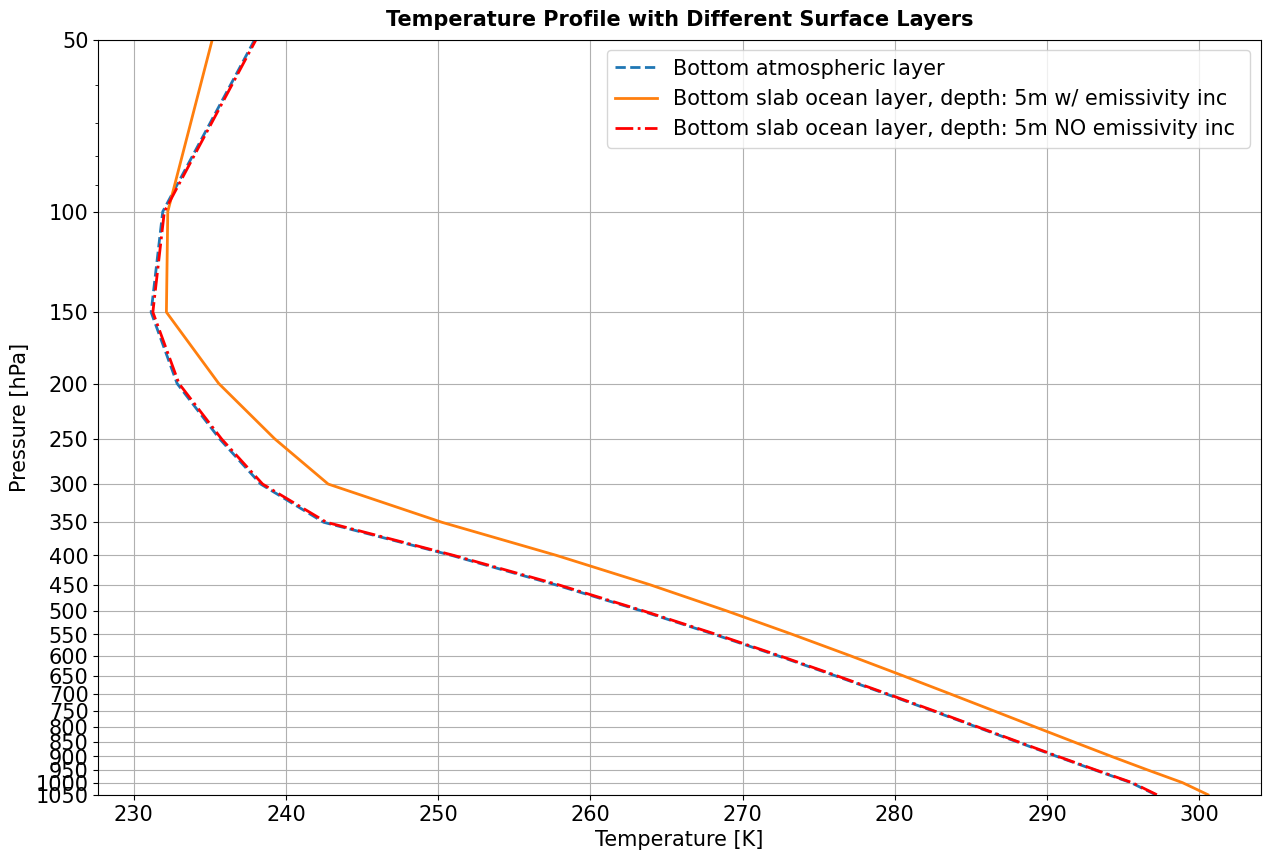

In [95]:
# T2 is the final T prof from project 2 (conv adjustment with atm surf layer)
with open('vars2.pkl','rb') as f:
    T2,theta2,lapse_rate2 = pickle.load(f)
    
# final_T_prof is the final temperature profile for ocean slab model, WITHOUT emissivity increase
with open('vars3.pkl','rb') as f:
    final_T_prof, final_outgoing_lw_toa = pickle.load(f)

# T_depth5 is final temp prof for ocean model WITH emissivity increase
# all depths should equilibriate to this
with open('T_depth5.pkl','rb') as f:
    T_depth5 = pickle.load(f)
T_depth5 = np.squeeze(T_depth5)
    
fig = plt.figure(figsize=(15,10))
gs1 = gs.GridSpec(2,2,figure=fig)

ax1 = fig.add_subplot(gs1[:,:])
plt.plot(T2[:],plev,linestyle='--',label='Bottom atmospheric layer')
plt.plot(T_depth5[:],plev,label='Bottom slab ocean layer, depth: 5m w/ emissivity inc ')
plt.plot(final_T_prof,plev,linestyle='-.',color='red',label='Bottom slab ocean layer, depth: 5m NO emissivity inc ')
plt.grid();
plt.yscale('log');
plt.ylim( (pow(10,4),pow(10,5)) )
plt.yticks(plev[:], [str(int(val/100)) for val in plev[:]]);
ax1.invert_yaxis(); # have this at end, plt.plot changes the axis back
plt.legend(loc='lower right',prop={'size':15})
plt.xlabel('Temperature [K]')
plt.ylabel('Pressure [hPa]')
plt.title('Temperature Profile with Different Surface Layers')
plt.legend(prop={'size':15})
# plt.savefig('/Users/tyler/Desktop/SP22/ATS_606/figs/Project3_a.png',dpi=400,bbox_inches='tight')

Experiment with different depths of the slab ocean layer: 1m, 2m, 5m, 20m, 50m, 100m, 200m out to equilibrium

In [126]:
# rerun ocean slab model with emissivity ON at different depths 
depths = [1,2,5,20,50,100,200]

# test with 1 year above

# set piecewise epsilon array vals  
mask = plev>80000
epsilon[mask] = 0.3
mask = (plev<=80000) & (plev>40000)
epsilon[mask] = 0.2
mask = plev<=40000
epsilon[mask] = 0.1
epsilon[0] = 1 # surface epsilon
# switch on increased LW emissivity for atm layers
epsilon[1:] = epsilon[1:] + 0.02
print(epsilon)

# create array to assign new temperatures to
T_all_depths = np.zeros([len(depths),len(plev),len(t)])

SH = np.zeros(len(t))

fig = plt.figure(figsize=(11,8))


tic()

for d,h in enumerate(depths):
    print('Currently running depth=', h,'m')
    # set initial condition every run 
    T[:,0] = final_T_prof

    # time loop
    for i in np.arange(0,len(t)-1):
    # for i in np.arange(0,1000-1):

        # upward LW stream #index good
        for j in np.arange(0,len(plev)):
            if j==0:
                emi_out = epsilon[j]*sigma*(T[j,i]**4)
                emi_in = 0 # no energy in from bottom layer
                trans = 0
                lw_up_bot[j,i] = 0
                lw_up_top[j,i] = emi_out + trans
            else: # for 1,...,20
                emi_out = epsilon[j]*sigma*(T[j,i]**4)
                emi_in = epsilon[j-1]*sigma*(T[j-1,i]**4)
                f_up[j,i] = emi_in + trans
                trans = (1-epsilon[j])*f_up[j,i]
                lw_up_bot[j,i] = f_up[j,i]

                lw_up_top[j,i] = emi_out + trans

        # downward LW stream  
        for j in np.arange(len(plev)-1,-1,-1):  # outputs 20 to 0, end @ 0 bc +1, starts at 20 bc +1 
            # correct index for layer 20 is len(plev)-1
            if j==20: # layer 20 (last atm layer)
                emi_out = epsilon[j]*sigma*(T[j,i]**4)
                emi_in = 0
                trans = 0
                lw_down_bot[j,i] = emi_out + trans
                lw_down_top[j,i] = 0
            elif j==0:
                lw_down_top[j,i] = emi_out + trans
                lw_down_bot[j,i] = 0
            else: # 19,18,...,1
                emi_out = epsilon[j]*sigma*(T[j,i]**4)
                emi_in = epsilon[j+1]*sigma*(T[j+1,i]**4)
                f_down[j,i] = emi_in + trans

                lw_down_top[j,i] = emi_in + trans
                trans = (1-epsilon[j])*f_down[j,i]
                lw_down_bot[j,i] = emi_out + trans

        # downward SW stream
        for j in np.arange(len(plev)-1,-1,-1): # index good
            if j==0:
                sw_down_top[j,i] = sw_down_bot[j+1,i]
                sw_down_bot[j,i] = 0 

            elif j==20:
                sw_down_top[j,i] = (So/4)*(1-a)
                sw_down_abs = 0.05*((So/4)*(1-a))
                sw_down_bot[j,i] = 0.95*(So/4)*(1-a)

            elif j==19:
                sw_down_top[j,i] = sw_down_bot[j+1,i]
                sw_down_abs = 0.025*sw_down_top[j,i]
                sw_down_bot[j,i] = (1-0.025)*sw_down_top[j,i]

            elif j==18:
                sw_down_top[j,i] = sw_down_bot[j+1,i]
                sw_down_abs = 0.0125*sw_down_top[j,i]
                sw_down_bot[j,i] = (1-0.0125)*sw_down_top[j,i]

            elif j==17:
                sw_down_top[j,i] = sw_down_bot[j+1,i]
                sw_down_abs = 0.00625*sw_down_top[j,i]
                sw_down_bot[j,i] = (1-0.00625)*sw_down_top[j,i]

            elif j==16:
                sw_down_top[j,i] = sw_down_bot[j+1,i]
                sw_down_abs = 0.003125*sw_down_top[j,i]
                sw_down_bot[j,i] = (1-0.003125)*sw_down_top[j,i]
            else:
                sw_down_top[j,i] = sw_down_bot[j+1,i]
                sw_down_bot[j,i] = sw_down_bot[j+1,i]          
    #   ################################ SENSIBLE HEAT ########################################
        # calculate (broadcast) net radiation in each layer for time step i
        dF[:,i] = lw_up_bot[:,i] - lw_up_top[:,i] + lw_down_top[:,i] \
        - lw_down_bot[:,i] + sw_down_top[:,i] - sw_down_bot[:,i]

        SH[i] = rho*cp*Ce*V*(T[0,i]-T[1,i])

        dF[0,i] = dF[0,i] - SH[i]
        dF[1,i] = dF[1,i] + SH[i]

        # calculate temperature array
        T[:,i+1] = T[:,i] + dF[:,i]/(m*cp)*dt
        T[0,i+1] = T[0,i] + dF[0,i]/(rhow*h*cw)*dt
        T[1,i+1] = T[1,i] + dF[1,i]/(m*cp)*dt

        # calculate potential temperature 
        theta[:,i] = T[:,i]*((np.ones(21)*105000)/(plev[:]))**(0.286)

        ##### check if T has nan
        if np.isnan(T[:,i]).all():
            print('Index: ', i, 'Temperatures are NaNs')
            break


    # ######################################## CONVECTIVE ADJUSTMENT STEPS ########################################
    #     test with:
    #     gamma_crit = 6.5

        for j in range(1,len(plev)-1): # one less layer, b/c layer pair
    #         # step to adjust for bottom layer adjustments
            if j in [1,2,3,4,5]:

                # if j=0,:5: do convective adjustment again
                # calc gamma env
                dz = (Rd*T[j,i+1]/g)*np.log((plev[j]-2500)/(plev[j+1]-2500))
                lapse_rate = -1*(T[j+1,i+1]-T[j,i+1])/dz*1000

                # calc dq/dT using metpy
                dq_star = (saturation_mixing_ratio( (plev[j+1]-2500)*units.Pa, (T[j+1,i+1])*units.K) - \
                           saturation_mixing_ratio( (plev[j]-2500)*units.Pa, (T[j,i+1])*units.K)).magnitude
                dT = T[j+1,i+1]-T[j,i+1]
                dqdT = dq_star/dT
                gamma_crit = 9.8/(1+(L*dqdT/cp))
            #         print('time:', i, 'plev:',plev[j],lapse_rate, gamma_crit)
            #         print('dqdt',dqdt)

                tolerance = 0.1
                while lapse_rate > gamma_crit+tolerance: #unstable atm
                    # do convective adjustment
            #             T[j+1,i+1] = ((T[j,i+1] + T[j+1,i+1] - (gamma_crit/1000)*dz[j,i+1]))/2
            #             T[j,i+1] = T[j+1,i+1] + (gamma_crit/1000)*dz[j,i+1]
                    T[j+1,i+1] = (T[j,i+1] + T[j+1,i+1] - (gamma_crit/1000)*dz)/2
                    T[j,i+1] = T[j+1,i+1] + (gamma_crit/1000)*dz


                    lapse_rate = -1*(T[j+1,i+1]-T[j,i+1])/dz*1000
            else: 

                # if j=0,:5: do convective adjustment again
                # calc gamma env
                dz = (Rd*T[j,i+1]/g)*np.log((plev[j]-2500)/(plev[j+1]-2500))
                lapse_rate = -1*(T[j+1,i+1]-T[j,i+1])/dz*1000

                # calc dq/dT using metpy
                dq_star = (saturation_mixing_ratio( (plev[j+1]-2500)*units.Pa, (T[j+1,i+1])*units.K) - \
                           saturation_mixing_ratio( (plev[j]-2500)*units.Pa, (T[j,i+1])*units.K)).magnitude
                dT = T[j+1,i+1]-T[j,i+1]
                dqdT = dq_star/dT
                gamma_crit = 9.8/(1+(L*dqdT/cp))
            #         print('time:', i, 'plev:',plev[j],lapse_rate, gamma_crit)
            #         print('dqdt',dqdt)

                tolerance = 0.1
                while lapse_rate > gamma_crit+tolerance: #unstable atm
                    # do convective adjustment
            #             T[j+1,i+1] = ((T[j,i+1] + T[j+1,i+1] - (gamma_crit/1000)*dz[j,i+1]))/2
            #             T[j,i+1] = T[j+1,i+1] + (gamma_crit/1000)*dz[j,i+1]
                    T[j+1,i+1] = (T[j,i+1] + T[j+1,i+1] - (gamma_crit/1000)*dz)/2
                    T[j,i+1] = T[j+1,i+1] + (gamma_crit/1000)*dz


                    lapse_rate = -1*(T[j+1,i+1]-T[j,i+1])/dz*1000
    # end of time loop for single depth
    # save in array
    T_all_depths[d,:,:] = T[:,:]
    
# 4 year test
# T_all_depths4yr = T_all_depths[:,:,:]
# # store variables for later use
# with open('T_all_depths4yr.pkl','wb') as f:
#     pickle.dump([T_all_depths4yr],f)

# 20 years
# T_all_depths20yr = T_all_depths
# #store var
# with open('T_all_depths20yr.pkl','wb') as f:
#     pickle.dump([T_all_depths20yr],f)
toc()

[1.   0.32 0.32 0.32 0.32 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.12
 0.12 0.12 0.12 0.12 0.12 0.12 0.12]
Currently running depth= 1 m
Currently running depth= 2 m
Currently running depth= 5 m
Currently running depth= 20 m
Currently running depth= 50 m
Currently running depth= 100 m
Currently running depth= 200 m
Elapsed time is 14242.664766788483 seconds.


<Figure size 1100x800 with 0 Axes>

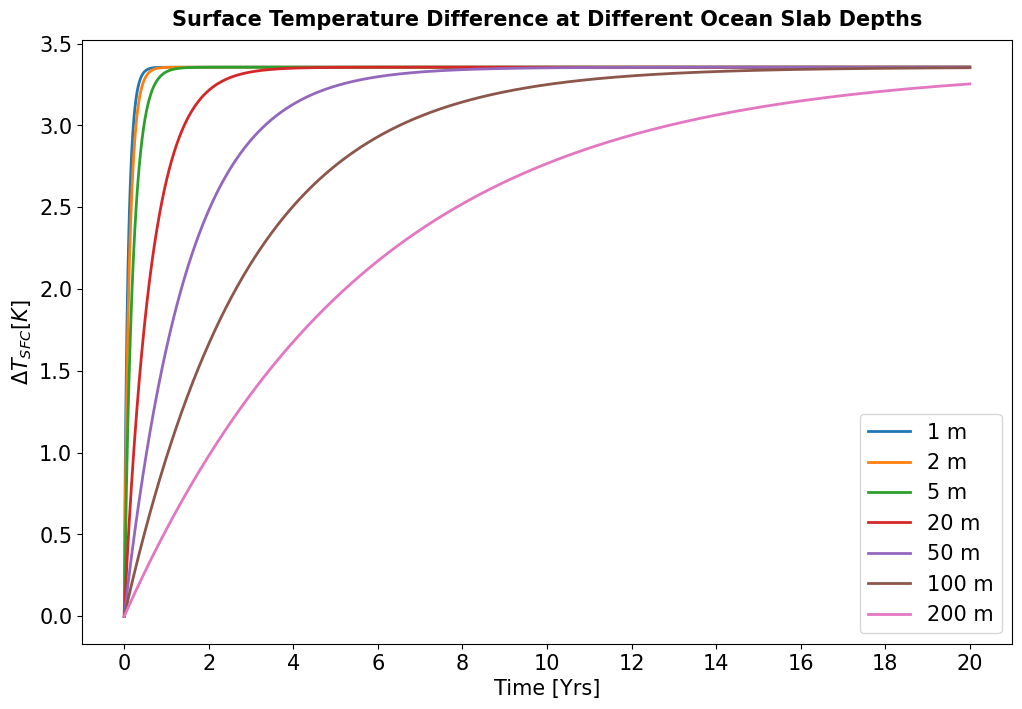

In [142]:
# with open('T_all_depths4yr.pkl','rb') as f:
#     T_all_depths_copy = pickle.load(f)
# T_all_depths_copy = np.squeeze(T_all_depths_copy)

with open('T_all_depths20yr.pkl','rb') as f:
    T_all_depths20yr_copy = pickle.load(f)
T_all_depths20yr_copy = np.squeeze(T_all_depths20yr_copy)

fig = plt.figure(figsize=(12,8))

for i,d in enumerate(depths):
    label_str = str(depths[i])+' m'
#     plt.plot(np.arange(0,len(t)),T_all_depths[i,0,:]-final_T_prof[0],label=label_str)
#     plt.plot(np.arange(0,len(t)),T_all_depths_copy[i,0,:]-final_T_prof[0],label=label_str)
    plt.plot(np.arange(0,len(t)),T_all_depths20yr_copy[i,0,:]-final_T_prof[0],label=label_str)


plt.legend(prop={'size':15})
plt.title('Surface Temperature Difference at Different Ocean Slab Depths')
plt.xlabel('Time [Yrs]')
plt.ylabel(r'$\Delta T_{SFC} [K] $')
plt.xticks(np.arange(0,22*8760,2*8760),[str(yr) for yr in np.arange(0,22,2)]);
plt.savefig('/Users/tyler/Desktop/SP22/ATS_606/figs/Project3_T_surf_depths.png',dpi=400,bbox_inches='tight')